<a href="https://colab.research.google.com/github/MrKozelberg/wavefunction_perceptron/blob/spectrum_laplace_operator/spectrum_laplace_operator_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the perceptron to the Laplace operator's eigen-problem

## Imports

In [1]:
import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn

from scipy.optimize import minimize

## Detect available device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Definition of an activation function and its derivatives

In [3]:
def f0(x):
    return torch.tanh(x)
  
def f1(x):
  return 1/torch.cosh(x)**2
  
def f2(x):
  return -2*torch.sinh(x)/torch.cosh(x)**3

## Class for the perceptron-wavefunction 

In [4]:
class Perceptron(nn.Module):

  def __init__(self, N, layersizes):
    self.N = N  # size of the input vector
    self.layersizes = layersizes  # sizes of hidden layers
    self.l = len(self.layersizes)  # number of hidden layers

    super(Perceptron, self).__init__()
        
    self.linear_tanh_stack = nn.Sequential()
    for i in range(self.l + 1):
      if i == 0:
        self.linear_tanh_stack.append(nn.Linear(N, self.layersizes[i]))
      elif i == self.l:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1], 1))
      else:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1],
                                                self.layersizes[i]))
      self.linear_tanh_stack.append(nn.Tanh())
    
    self.h = [None] * (self.l + 1)  # outputs of the layers

  
  def forward(self, x):
    for i in range(self.l + 1):
      if i == 0:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](x))
      else:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](self.h[i-1]))
      
    return self.h[-1] / torch.linalg.vector_norm(self.h[-1])


  def grad(self, x):
    """
    finds the gradient of the wave function at a given point x
    """
    _ = self.forward(x)  # computes outputs of the layers #
    gradient = torch.zeros(x.shape).to(device)
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device) #
      dh_dx[t] = 1 # 

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)   
        
      # print(dh_dx.shape, gradient[t].shape)
      
      gradient[:,t] = dh_dx.reshape(-1)

    return gradient / torch.linalg.vector_norm(self.h[-1])
  

  def laplac(self, x):
    """
    finds the Laplacian of the wave function at a given point x
    """
    y = self.forward(x)  # computes outputs of the layers
    laplacian = 0.0
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device)
      dh_dx[t] = 1

      d2h_dx2 = torch.zeros(self.N).to(device)

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        # firstly, the new value of the second derivative computes as it is 
        # used the previous value of the first derivative

        if i == 0:
          d2h_dx2 = f2(x @ w.T + b) * (dh_dx @ w.T)**2
        else:
          d2h_dx2 = f2(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)**2\
                    + f1(self.h[i-1] @ w.T + b) * (d2h_dx2 @ w.T)

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T) 
      
      # print(d2h_dx2)
      laplacian += d2h_dx2
    
    return laplacian / torch.linalg.vector_norm(self.h[-1])

In [5]:
def A(x_, L=1.0):
  p = torch.ones(x_.shape[0]).to(device)

  for i in range(x_.shape[1]):
    p *= (x_[:,i] - L/2)**2-L**2/4

  return p
  
def Ax(x_, L=1.0):
  p = torch.ones(x_.shape).to(device)

  for i in range(x_.shape[1]):
    p[:, i] = A(x_, L) * 2 * (x_[:,i] - L/2) / ((x_[:,i] - L/2)**2-L**2/4)

  return p
  
def Axx(x_, L=1.0):
  return 2 * A(x_,L) * torch.sum( ((x_ - L/2)**2 - L**2/4)**(-1), axis=1 )

def train_loop_groundstate(N, n_batch, epochs, perceptron, L=1.0):
  optimizer = torch.optim.Adam(params = perceptron.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999) #ReduceLROnPlateau(optimizer,
                                                        #  'min',
                                                        #  factor=0.25,
                                                        #  patience=500,
                                                        #  eps=0) 
  loss_fn = nn.L1Loss()

  residual = np.zeros(epochs, dtype=float)
  E = np.zeros(epochs, dtype=float)

  for epoch in range(epochs):
    x_test = torch.rand((n_batch[epoch], N)).to(device) * L

    phi_test = perceptron(x_test).reshape(len(x_test)).to(device)
    phix_test = perceptron.grad(x_test).to(device)
    phixx_test = perceptron.laplac(x_test).reshape(len(x_test)).to(device)

    res = torch.mean((-(phixx_test * A(x_test,L) \
                     + 2 * torch.sum(Ax(x_test,L) * phix_test, axis=1) \
                     + Axx(x_test,L) * phi_test) \
                     - torch.mean(-(phixx_test * A(x_test,L)\
                     + 2 * torch.sum(Ax(x_test,L) * phix_test, axis=1)\
                     + Axx(x_test,L) * phi_test) * phi_test * A(x_test,L))\
        / torch.mean((phi_test * A(x_test,L))**2) * phi_test * A(x_test,L))**2)
    
    # Compute loss
    loss = loss_fn(res, torch.tensor(0.0).to(device))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    residual[epoch] = loss.item()
    E[epoch] = torch.mean(-(phixx_test * A(x_test,L)\
                     + 2 * torch.sum(Ax(x_test,L) * phix_test, axis=1)\
                     + Axx(x_test,L) * phi_test) * phi_test * A(x_test,L))\
               / torch.mean((phi_test * A(x_test,L))**2)

    if np.isnan(loss.item()):
      print(f'{epoch:} LOSS FUNCTION IS NAN')
      break

    if (epoch+1) % 1000 == 0:
      print(f"[{epoch+1:>5d} / {epochs:>5d}] Residual: {residual[epoch]:>0.5E},"
           f" Energy: {E[epoch]:>0.5f}")
    
  scheduler.step()#loss.item())

  return residual, E

# 1D

In [6]:
def plot_compar_1d_groundstate(perceptron, L=1.0):
  x = torch.linspace(1e-2,L-1e-2,100).reshape((-1, N)).to(device)
  y = perceptron(x) * A(x, L).reshape((-1,N))

  x = x.cpu().detach().numpy()
  y = y.cpu().detach().numpy()

  plt.plot(x, (y/y.mean())**2,
           label='What we get')
  
  plt.plot(x, (np.sin(x*np.pi/L)/np.sin(x*np.pi/L).mean())**2,
           label='What we should get')

  plt.legend()
  plt.xlim(0,L)
  plt.ylim(0.0,None)

  plt.show()

## Initialization of our wavefunction

In [45]:
N = 1  # size of the input vector
perceptron0 = Perceptron(N, [10]*).to(device)

## Its training

In [46]:
epochs = 10000
n_batch = np.logspace(1, 2, epochs, dtype=int)

residual, E = train_loop_groundstate(N, n_batch, epochs, perceptron0, L=1)

[ 1000 / 10000] Residual: 2.69141E-05, Energy: 9.87794
[ 2000 / 10000] Residual: 1.47145E-05, Energy: 9.86502
[ 3000 / 10000] Residual: 2.16263E-05, Energy: 9.87081
[ 4000 / 10000] Residual: 3.71452E-06, Energy: 9.86439
[ 5000 / 10000] Residual: 3.46405E-06, Energy: 9.86054
[ 6000 / 10000] Residual: 5.19610E-06, Energy: 9.87104
[ 7000 / 10000] Residual: 9.07081E-07, Energy: 9.87175
[ 8000 / 10000] Residual: 6.11022E-07, Energy: 9.86720
[ 9000 / 10000] Residual: 8.56608E-07, Energy: 9.87024
[10000 / 10000] Residual: 2.11360E-07, Energy: 9.87280


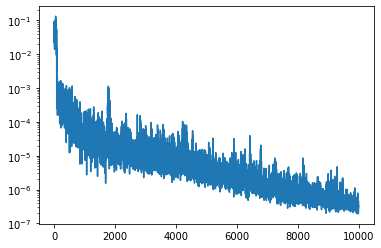

In [47]:
plt.plot(residual)
plt.yscale('log')

(0.0, 10000.0)

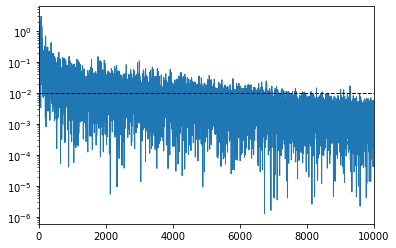

In [48]:
plt.plot(abs(E - np.pi**2), linewidth=1)
plt.yscale('log')
plt.axhline(y=1e-2, linewidth=1, linestyle='--', color='black')
plt.xlim(0,len(E))

In [49]:
def I(x):
  return np.mean((E[7000:] - x[0] - x[2] * np.exp(x[1]*np.arange(7000, 7000+len(E[7000:]))))**2)

x0 = [9, -10, -1/2]

res = minimize(I, x0, method='Powell', tol=1e-6)

In [51]:
res.x[0] - np.pi**2

0.00018521167072371725

# 1 STATE

In [110]:
def train_loop_1state(N, n_batch, epochs, perceptron, perceptron0, L=1.0):
  optimizer = torch.optim.Adam(params = perceptron.parameters(), lr=1e-3)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)#ReduceLROnPlateau(optimizer,
                                                        #  'min',
                                                        #  factor=0.25,
                                                        #  patience=500,
                                                        #  eps=0) 
  loss_fn = nn.L1Loss()

  residual = np.zeros(epochs, dtype=float)
  E = np.zeros(epochs, dtype=float)

  for epoch in range(epochs):
    x_test = torch.rand((n_batch[epoch], N)).to(device) * L

    coef = torch.mean(A(x_test)**2 \
                      * perceptron(x_test) \
                      * perceptron0(x_test)) \
           / torch.mean(A(x_test)**2 \
                      * perceptron0(x_test)**2)

    phi_test = (perceptron(x_test) - coef * perceptron0(x_test)).reshape(len(x_test)).to(device)
    phix_test = (perceptron.grad(x_test) - coef * perceptron0.grad(x_test)).to(device)
    phixx_test = (perceptron.laplac(x_test) - coef * perceptron0.laplac(x_test)).reshape(len(x_test)).to(device)

    res = torch.mean((-(phixx_test * A(x_test,L) \
                     + 2 * torch.sum(Ax(x_test,L) * phix_test, axis=1) \
                     + Axx(x_test,L) * phi_test) \
                     - torch.mean(-(phixx_test * A(x_test,L)\
                     + 2 * torch.sum(Ax(x_test,L) * phix_test, axis=1)\
                     + Axx(x_test,L) * phi_test) * phi_test * A(x_test,L))\
        / torch.mean((phi_test * A(x_test,L))**2) * phi_test * A(x_test,L))**2)
    
    # Compute loss
    loss = loss_fn(res, torch.tensor(0.0).to(device))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    residual[epoch] = loss.item()
    E[epoch] = torch.mean(-(phixx_test * A(x_test,L)\
                     + 2 * torch.sum(Ax(x_test,L) * phix_test, axis=1)\
                     + Axx(x_test,L) * phi_test) * phi_test * A(x_test,L))\
               / torch.mean((phi_test * A(x_test,L))**2)

    if np.isnan(loss.item()):
      print(f'{epoch:} LOSS FUNCTION IS NAN')
      break

    if (epoch+1) % 1000 == 0:
      print(f"[{epoch+1:>5d} / {epochs:>5d}] Residual: {residual[epoch]:>0.5E},"
           f" Energy: {E[epoch]:>0.5f}")
    
  scheduler.step()

  return residual, E

In [111]:
N = 1  # size of the input vector
perceptron1 = Perceptron(N, [10]*4).to(device)

In [125]:
epochs = 50000
n_batch = np.logspace(1, 2.5, epochs, dtype=int)

residual, E = train_loop_1state(N, n_batch, epochs, perceptron1, perceptron0, L=1)

[ 1000 / 50000] Residual: 2.39500E-05, Energy: 28.38558
[ 2000 / 50000] Residual: 9.07675E-06, Energy: 38.47263
[ 3000 / 50000] Residual: 8.69605E-06, Energy: 37.47346
[ 4000 / 50000] Residual: 6.73969E-07, Energy: 35.01269
[ 5000 / 50000] Residual: 2.73556E-06, Energy: 47.76577
[ 6000 / 50000] Residual: 2.33530E-07, Energy: 180.55876
[ 7000 / 50000] Residual: 6.24095E-07, Energy: 41.45138
[ 8000 / 50000] Residual: 1.48328E-06, Energy: 44.91695
[ 9000 / 50000] Residual: 1.44146E-07, Energy: 83.82355
[10000 / 50000] Residual: 2.26399E-07, Energy: 53.96471
[11000 / 50000] Residual: 1.42443E-06, Energy: 49.07506
[12000 / 50000] Residual: 1.76023E-07, Energy: 61.06933
[13000 / 50000] Residual: 5.15948E-05, Energy: 45.49997
[14000 / 50000] Residual: 4.39129E-07, Energy: 69.63171
[15000 / 50000] Residual: 5.03152E-07, Energy: 41.05746
[16000 / 50000] Residual: 2.04605E-07, Energy: 54.75654
[17000 / 50000] Residual: 2.08872E-06, Energy: 47.00272
[18000 / 50000] Residual: 1.22070E-07, Energy: 

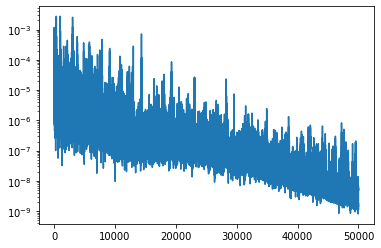

In [128]:
plt.plot(residual)
plt.yscale('log')

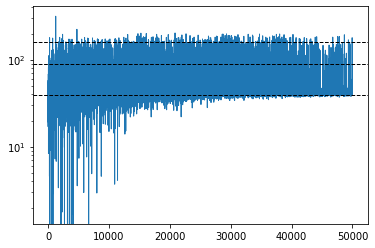

In [130]:
plt.plot(E, linewidth=1)
plt.axhline(y=4*np.pi**2, linewidth=1, linestyle='--', color='black')
plt.axhline(y=9*np.pi**2, linewidth=1, linestyle='--', color='black')
plt.axhline(y=16*np.pi**2, linewidth=1, linestyle='--', color='black')
plt.yscale('log')

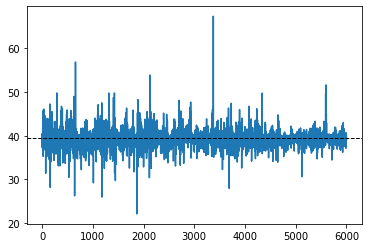

In [137]:
plt.plot(E[20000:].reshape((5,-1)).min(axis=0))
plt.axhline(y=4*np.pi**2, linewidth=1, linestyle='--', color='black')


(array([1.000e+00, 1.000e+00, 5.000e+00, 1.800e+01, 2.030e+02, 1.724e+03,
        1.137e+03, 5.020e+02, 3.030e+02, 2.290e+02, 2.090e+02, 1.620e+02,
        1.570e+02, 1.440e+02, 1.220e+02, 1.120e+02, 1.010e+02, 6.700e+01,
        7.500e+01, 6.100e+01, 5.900e+01, 5.200e+01, 4.500e+01, 4.400e+01,
        4.000e+01, 3.200e+01, 3.600e+01, 2.500e+01, 2.200e+01, 2.200e+01,
        4.100e+01, 2.400e+01, 2.100e+01, 2.200e+01, 2.300e+01, 2.000e+01,
        1.500e+01, 1.500e+01, 2.000e+01, 1.200e+01, 1.300e+01, 1.300e+01,
        1.300e+01, 7.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 4.000e+00,
        5.000e+00, 4.000e+00]),
 array([ 22.98853302,  25.96424484,  28.93995667,  31.91566849,
         34.89138031,  37.86709213,  40.84280396,  43.81851578,
         46.7942276 ,  49.76993942,  52.74565125,  55.72136307,
         58.69707489,  61.67278671,  64.64849854,  67.62421036,
         70.59992218,  73.575634  ,  76.55134583,  79.52705765,
         82.50276947,  85.47848129,  88.45419312,  91.42

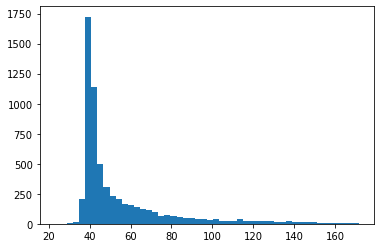

In [117]:
plt.hist(E[4000:], bins=50)

In [96]:
def I(x):
  return np.mean((E[7000:] - x[0] - x[2] * np.exp(x[1]*np.arange(7000, 7000+len(E[7000:]))))**2)

x0 = [9, -10, -1/2]

res = minimize(I, x0, method='Powell', tol=1e-6)

res.x[0], 4*np.pi**2

(43.09652251249869, 39.47841760435743)

# 2D

In [ ]:
def plot_compare_2d(wf):
  n = 100 # number of points over one dimension
  x = np.linspace(0,1,n)
  xs, ys = np.meshgrid(x,x, sparse=True)
  
  X = np.array([[xs[0,i], ys[j,0]] for i in range(100) for j in range(100)])
  X = torch.tensor(X).to(device)

  phi = wf(X.float()).reshape(len(X)).to(device) \
        * A(X.float()).reshape(len(X)).to(device)
  sin = torch.sin(np.pi*X[:,0].float())*torch.sin(np.pi*X[:,1].float())

  phi = phi.reshape(100,100).cpu().detach().numpy()
  sin = sin.reshape(100,100).cpu().detach().numpy()

  fig, ax = plt.subplots(1, 2, figsize=(14,5))

  pcm0 = ax[0].contourf(x, x, (phi/phi.mean())**2)

  fig.colorbar(pcm0, ax=ax[0], extend='max')

  pcm1 = ax[1].contourf(x, x, (sin/sin.mean())**2)

  fig.colorbar(pcm1, ax=ax[1], extend='max')

  ax[0].set_xlabel(r'$x_1$')
  ax[0].set_ylabel(r'$x_2$')

  ax[1].set_xlabel(r'$x_1$')
  ax[1].set_ylabel(r'$x_2$')

  ax[0].set_title(r'What $|\psi|^2$ we get')
  ax[1].set_title(r'What $|\psi|^2$ we should get')

  plt.show()

In [ ]:
N = 2
wf = WaveFunction(N, [10**N]*3).to(device) 


 Epoch 1
-------------------------------
Residual: 1.71739E-07, Energy: 19.74167  [  100 /  1000]
Residual: 9.69896E-08, Energy: 19.71354  [  200 /  1000]
Residual: 5.07770E-08, Energy: 19.77686  [  300 /  1000]
Residual: 2.54083E-08, Energy: 19.67511  [  400 /  1000]
Residual: 2.02960E-08, Energy: 19.80929  [  500 /  1000]
Residual: 1.49733E-08, Energy: 19.77270  [  600 /  1000]
Residual: 1.35413E-08, Energy: 19.72877  [  700 /  1000]
Residual: 1.52424E-08, Energy: 19.67227  [  800 /  1000]
Residual: 9.62344E-09, Energy: 19.82093  [  900 /  1000]
Residual: 7.53004E-09, Energy: 19.73412  [ 1000 /  1000]


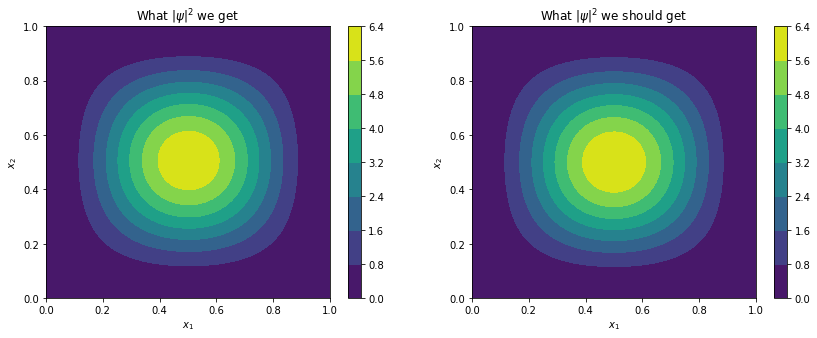


 Epoch 2
-------------------------------
Residual: 6.79319E-09, Energy: 19.72321  [  100 /  1000]
Residual: 1.09989E-08, Energy: 19.69460  [  200 /  1000]
Residual: 7.66023E-09, Energy: 19.75354  [  300 /  1000]
Residual: 7.45130E-09, Energy: 19.70572  [  400 /  1000]
Residual: 2.67152E-08, Energy: 19.71713  [  500 /  1000]
Residual: 2.07187E-08, Energy: 19.70362  [  600 /  1000]
Residual: 1.27860E-07, Energy: 19.69390  [  700 /  1000]
Residual: 6.11717E-07, Energy: 19.99356  [  800 /  1000]
Residual: 6.96834E-07, Energy: 20.20104  [  900 /  1000]
Residual: 9.57992E-07, Energy: 26.48445  [ 1000 /  1000]


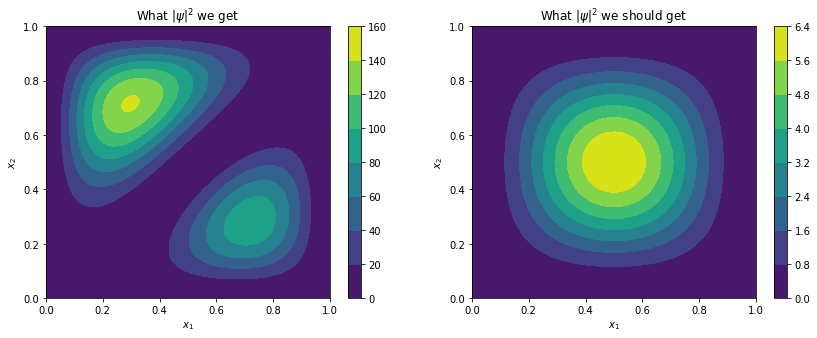


 Epoch 3
-------------------------------
Residual: 7.37498E-09, Energy: 19.91315  [  100 /  1000]
Residual: 1.75337E-09, Energy: 19.76535  [  200 /  1000]
Residual: 9.11077E-10, Energy: 19.72013  [  300 /  1000]
Residual: 6.63780E-10, Energy: 19.73999  [  400 /  1000]
Residual: 4.60453E-10, Energy: 19.71646  [  500 /  1000]
Residual: 1.87051E-10, Energy: 19.72606  [  600 /  1000]
Residual: 2.77589E-10, Energy: 19.75102  [  700 /  1000]
Residual: 1.83685E-10, Energy: 19.73141  [  800 /  1000]
Residual: 2.14301E-10, Energy: 19.71097  [  900 /  1000]
Residual: 2.00077E-10, Energy: 19.72943  [ 1000 /  1000]


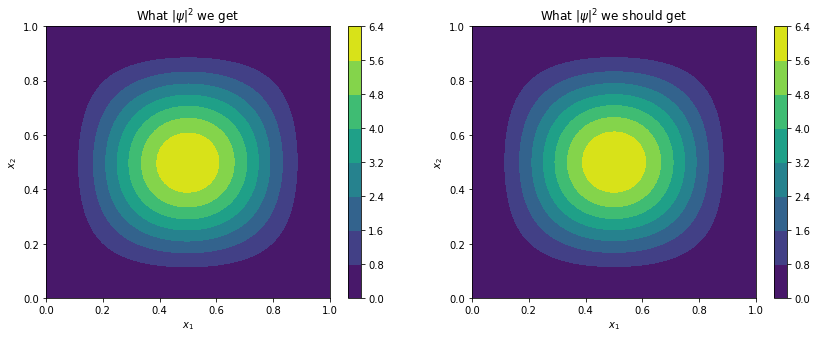


 Epoch 4
-------------------------------
Residual: 1.65248E-10, Energy: 19.78170  [  100 /  1000]
Residual: 2.58201E-10, Energy: 19.75872  [  200 /  1000]
Residual: 1.53975E-10, Energy: 19.71521  [  300 /  1000]
Residual: 1.48704E-10, Energy: 19.71940  [  400 /  1000]
Residual: 1.88786E-10, Energy: 19.69991  [  500 /  1000]
Residual: 1.39854E-10, Energy: 19.70713  [  600 /  1000]
Residual: 1.58611E-10, Energy: 19.73598  [  700 /  1000]
Residual: 1.47180E-10, Energy: 19.76527  [  800 /  1000]
Residual: 1.86551E-10, Energy: 19.73284  [  900 /  1000]
Residual: 1.27704E-10, Energy: 19.75473  [ 1000 /  1000]


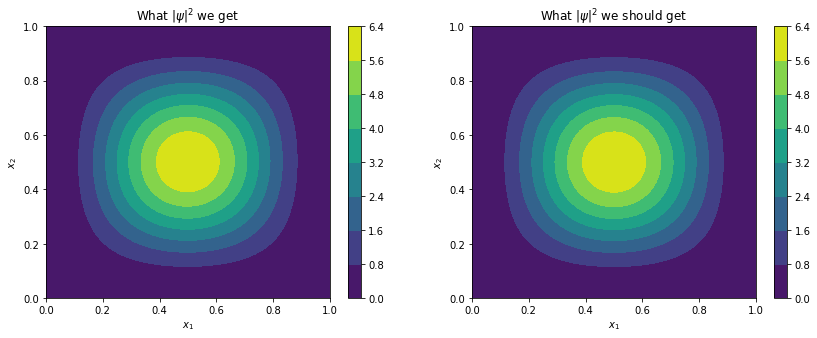


 Epoch 5
-------------------------------
Residual: 1.65721E-10, Energy: 19.73658  [  100 /  1000]
Residual: 1.59124E-10, Energy: 19.72189  [  200 /  1000]
Residual: 2.41209E-10, Energy: 19.74140  [  300 /  1000]
Residual: 1.07057E-10, Energy: 19.71883  [  400 /  1000]
Residual: 7.36195E-10, Energy: 19.70197  [  500 /  1000]
Residual: 2.25059E-10, Energy: 19.74687  [  600 /  1000]
Residual: 2.20049E-10, Energy: 19.74134  [  700 /  1000]
Residual: 2.80791E-10, Energy: 19.71916  [  800 /  1000]
Residual: 9.13393E-10, Energy: 19.73223  [  900 /  1000]
Residual: 6.70274E-08, Energy: 19.61060  [ 1000 /  1000]


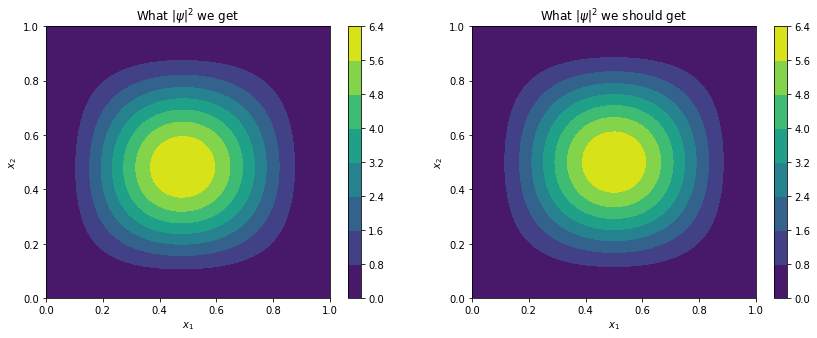


 Epoch 6
-------------------------------
Residual: 1.94204E-08, Energy: 22.68641  [  100 /  1000]
Residual: 1.99732E-10, Energy: 20.26415  [  200 /  1000]
Residual: 8.61633E-11, Energy: 20.93635  [  300 /  1000]
Residual: 3.01864E-11, Energy: 19.72216  [  400 /  1000]
Residual: 1.56025E-11, Energy: 19.91346  [  500 /  1000]
Residual: 1.54040E-11, Energy: 19.81884  [  600 /  1000]
Residual: 9.49232E-12, Energy: 19.76218  [  700 /  1000]
Residual: 8.95088E-12, Energy: 19.75696  [  800 /  1000]
Residual: 8.84263E-12, Energy: 19.75453  [  900 /  1000]
Residual: 8.08127E-12, Energy: 19.77881  [ 1000 /  1000]


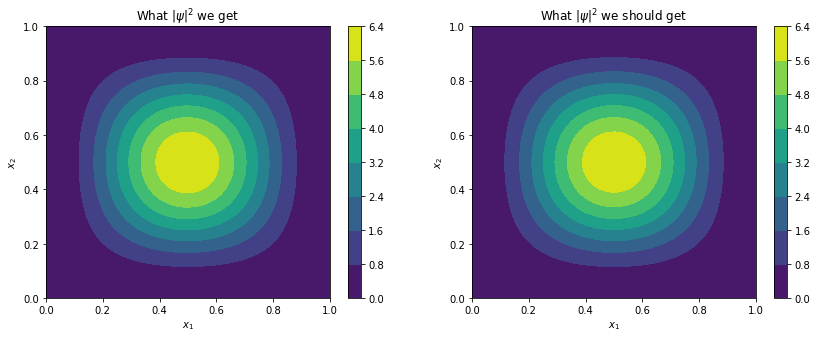


 Epoch 7
-------------------------------
Residual: 6.76507E-12, Energy: 19.77387  [  100 /  1000]
Residual: 9.03651E-12, Energy: 19.68642  [  200 /  1000]
Residual: 6.23038E-12, Energy: 19.73434  [  300 /  1000]
Residual: 1.11158E-11, Energy: 19.80048  [  400 /  1000]
Residual: 1.01165E-11, Energy: 19.82249  [  500 /  1000]
Residual: 8.28154E-12, Energy: 19.79737  [  600 /  1000]
Residual: 9.11932E-12, Energy: 19.77694  [  700 /  1000]
Residual: 1.00652E-11, Energy: 19.79817  [  800 /  1000]
Residual: 6.05250E-12, Energy: 19.78814  [  900 /  1000]
Residual: 1.03429E-11, Energy: 19.76727  [ 1000 /  1000]


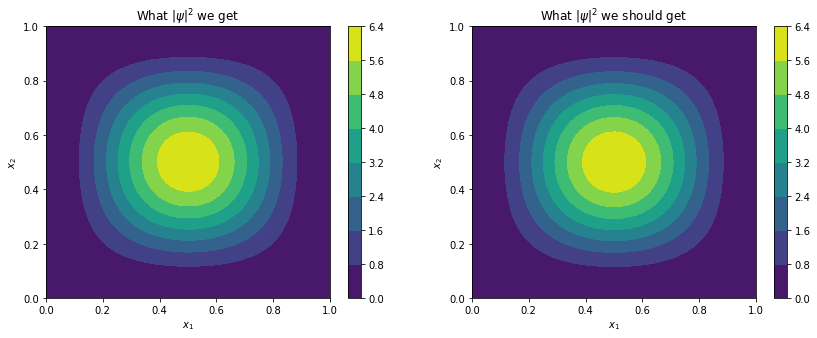


 Epoch 8
-------------------------------
Residual: 7.99913E-12, Energy: 19.75059  [  100 /  1000]
Residual: 5.43099E-12, Energy: 19.75069  [  200 /  1000]
Residual: 4.70054E-12, Energy: 19.74345  [  300 /  1000]
Residual: 7.36647E-12, Energy: 19.70837  [  400 /  1000]
Residual: 6.56451E-12, Energy: 19.74401  [  500 /  1000]
Residual: 1.46506E-11, Energy: 19.79326  [  600 /  1000]
Residual: 7.19195E-12, Energy: 19.72513  [  700 /  1000]
Residual: 4.89217E-12, Energy: 19.73512  [  800 /  1000]
Residual: 8.33840E-12, Energy: 19.75260  [  900 /  1000]
Residual: 4.67317E-12, Energy: 19.74694  [ 1000 /  1000]


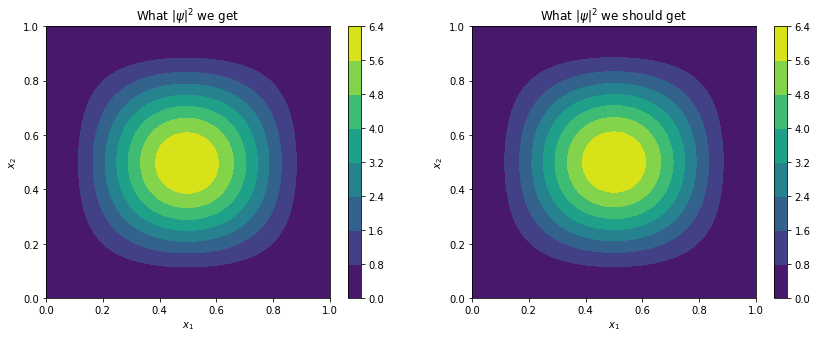


 Epoch 9
-------------------------------
Residual: 8.61788E-12, Energy: 19.73070  [  100 /  1000]
Residual: 1.25605E-11, Energy: 19.73379  [  200 /  1000]
Residual: 4.54494E-12, Energy: 19.73076  [  300 /  1000]
Residual: 3.91725E-12, Energy: 19.73979  [  400 /  1000]
Residual: 3.54402E-12, Energy: 19.75773  [  500 /  1000]
Residual: 2.17977E-11, Energy: 19.70143  [  600 /  1000]
Residual: 7.08741E-12, Energy: 19.73882  [  700 /  1000]
Residual: 5.37523E-12, Energy: 19.74950  [  800 /  1000]
Residual: 1.53622E-10, Energy: 20.07010  [  900 /  1000]
Residual: 9.45233E-08, Energy: 20.80775  [ 1000 /  1000]


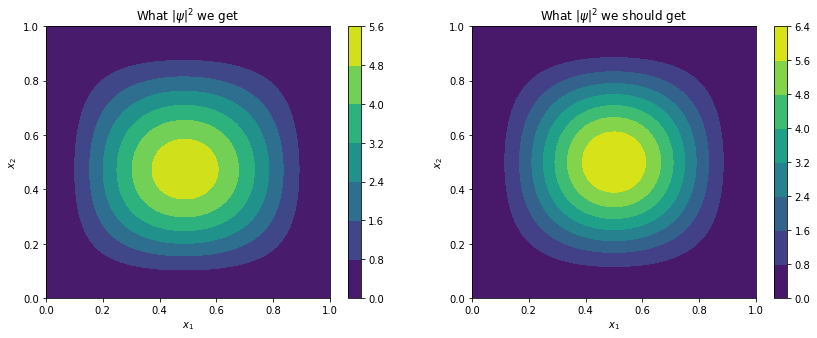


 Epoch 10
-------------------------------
Residual: 1.20957E-11, Energy: 20.00363  [  100 /  1000]
Residual: 2.28994E-12, Energy: 38.60533  [  200 /  1000]
Residual: 1.47948E-12, Energy: 19.51260  [  300 /  1000]
Residual: 1.93055E-12, Energy: 19.70814  [  400 /  1000]
Residual: 1.55212E-12, Energy: 19.70783  [  500 /  1000]
Residual: 1.45219E-12, Energy: 19.68091  [  600 /  1000]
Residual: 1.70452E-12, Energy: 19.78079  [  700 /  1000]
Residual: 1.41065E-12, Energy: 19.74927  [  800 /  1000]
Residual: 3.07096E-12, Energy: 19.78991  [  900 /  1000]
Residual: 1.47469E-12, Energy: 19.74905  [ 1000 /  1000]


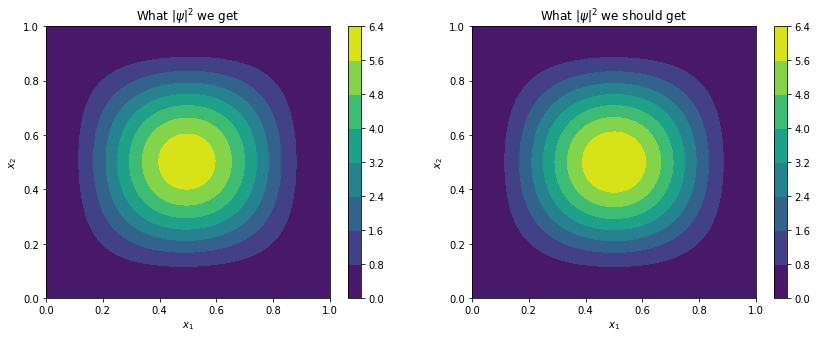


 Epoch 11
-------------------------------
Residual: 1.30170E-12, Energy: 19.81137  [  100 /  1000]
Residual: 9.05669E-13, Energy: 19.63193  [  200 /  1000]
Residual: 8.74510E-13, Energy: 19.67110  [  300 /  1000]
Residual: 8.92922E-13, Energy: 19.74660  [  400 /  1000]
Residual: 5.77952E-13, Energy: 19.76565  [  500 /  1000]
Residual: 8.31652E-13, Energy: 19.76145  [  600 /  1000]
Residual: 5.10211E-13, Energy: 19.78567  [  700 /  1000]
Residual: 4.95643E-13, Energy: 19.71738  [  800 /  1000]
Residual: 6.75203E-13, Energy: 19.82456  [  900 /  1000]
Residual: 1.10336E-12, Energy: 19.73730  [ 1000 /  1000]


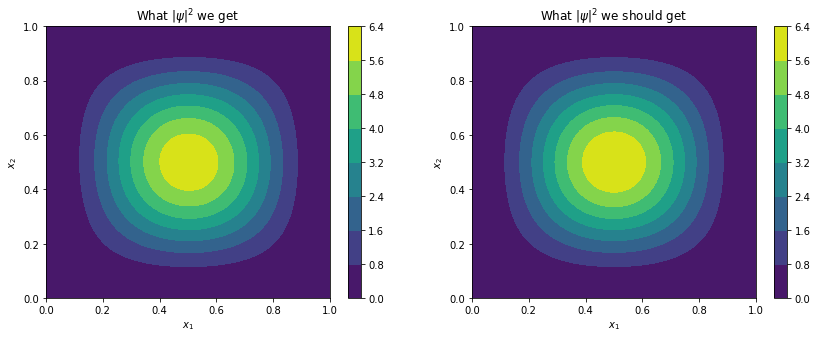


 Epoch 12
-------------------------------
Residual: 5.78935E-13, Energy: 19.83624  [  100 /  1000]
Residual: 4.80860E-13, Energy: 19.68229  [  200 /  1000]
Residual: 3.57016E-13, Energy: 19.71238  [  300 /  1000]
Residual: 3.86812E-13, Energy: 19.66095  [  400 /  1000]
Residual: 5.52955E-13, Energy: 19.88675  [  500 /  1000]
Residual: 5.79220E-13, Energy: 19.72396  [  600 /  1000]
Residual: 5.38366E-13, Energy: 19.98070  [  700 /  1000]
Residual: 3.42395E-13, Energy: 19.64559  [  800 /  1000]
Residual: 3.86018E-13, Energy: 19.92775  [  900 /  1000]
Residual: 4.10123E-13, Energy: 19.94856  [ 1000 /  1000]


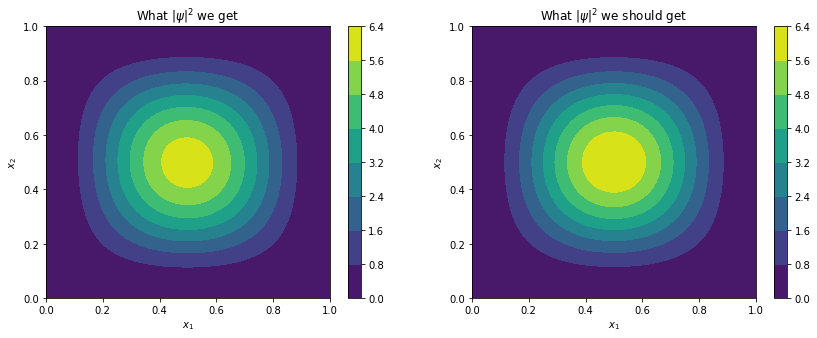


 Epoch 13
-------------------------------
Residual: 3.22872E-13, Energy: 19.70442  [  100 /  1000]
Residual: 3.23065E-13, Energy: 19.86411  [  200 /  1000]
Residual: 3.37645E-13, Energy: 19.53842  [  300 /  1000]
Residual: 2.59841E-13, Energy: 19.89782  [  400 /  1000]
Residual: 1.77794E-13, Energy: 19.84431  [  500 /  1000]
Residual: 2.24612E-13, Energy: 19.73690  [  600 /  1000]
Residual: 2.40124E-13, Energy: 19.64109  [  700 /  1000]
Residual: 4.09219E-13, Energy: 19.84003  [  800 /  1000]
Residual: 3.70665E-13, Energy: 19.87295  [  900 /  1000]
Residual: 4.79435E-13, Energy: 19.72852  [ 1000 /  1000]


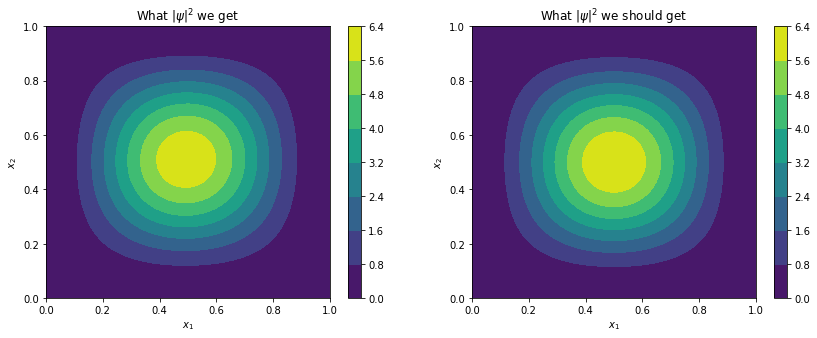


 Epoch 14
-------------------------------
Residual: 2.28156E-13, Energy: 19.65618  [  100 /  1000]
Residual: 2.85100E-13, Energy: 19.76071  [  200 /  1000]
Residual: 1.81727E-13, Energy: 19.73432  [  300 /  1000]
Residual: 2.04270E-13, Energy: 19.81142  [  400 /  1000]
Residual: 2.04616E-13, Energy: 19.78329  [  500 /  1000]
Residual: 3.18082E-12, Energy: 19.94934  [  600 /  1000]
Residual: 5.37458E-08, Energy: 19.06374  [  700 /  1000]
Residual: 9.33641E-11, Energy: 19.72646  [  800 /  1000]
Residual: 1.00140E-11, Energy: 19.74635  [  900 /  1000]
Residual: 6.13392E-12, Energy: 19.73265  [ 1000 /  1000]


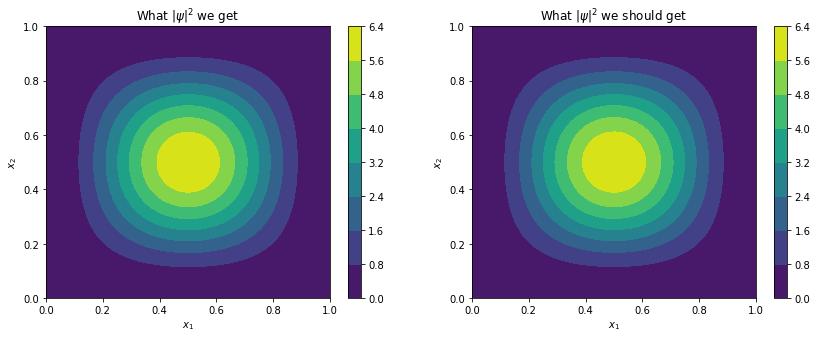


 Epoch 15
-------------------------------
Residual: 8.27454E-12, Energy: 19.74706  [  100 /  1000]
Residual: 6.24905E-12, Energy: 19.72418  [  200 /  1000]
Residual: 1.70545E-11, Energy: 19.75426  [  300 /  1000]
Residual: 2.91881E-12, Energy: 19.74027  [  400 /  1000]
Residual: 3.82900E-12, Energy: 19.79092  [  500 /  1000]
Residual: 2.53217E-12, Energy: 19.71250  [  600 /  1000]
Residual: 3.93611E-12, Energy: 19.78577  [  700 /  1000]
Residual: 3.82585E-11, Energy: 19.66089  [  800 /  1000]
Residual: 1.08333E-11, Energy: 19.71441  [  900 /  1000]
Residual: 1.58336E-07, Energy: 19.96081  [ 1000 /  1000]


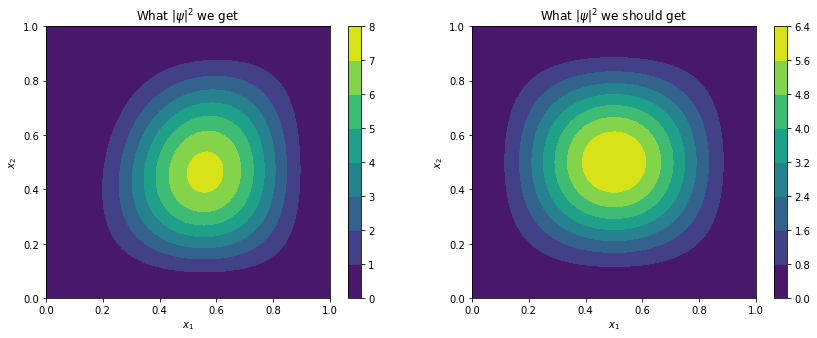


 Epoch 16
-------------------------------
Residual: 3.51990E-10, Energy: 19.74678  [  100 /  1000]
Residual: 1.67483E-10, Energy: 19.71198  [  200 /  1000]
Residual: 9.43769E-11, Energy: 19.74572  [  300 /  1000]
Residual: 9.91391E-11, Energy: 19.71337  [  400 /  1000]
Residual: 5.92192E-11, Energy: 19.72971  [  500 /  1000]
Residual: 3.14420E-11, Energy: 19.73142  [  600 /  1000]
Residual: 3.73018E-11, Energy: 19.72636  [  700 /  1000]
Residual: 1.84799E-11, Energy: 19.74687  [  800 /  1000]
Residual: 1.45300E-11, Energy: 19.74376  [  900 /  1000]
Residual: 1.08850E-11, Energy: 19.74965  [ 1000 /  1000]


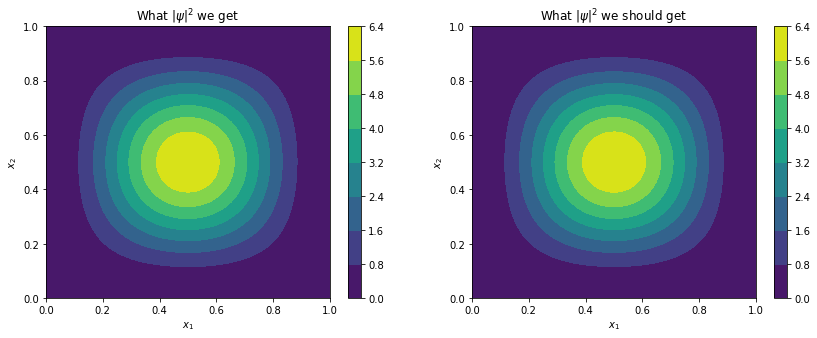


 Epoch 17
-------------------------------
Residual: 1.31800E-11, Energy: 19.73313  [  100 /  1000]
Residual: 5.44231E-12, Energy: 19.74118  [  200 /  1000]
Residual: 5.22697E-12, Energy: 19.73779  [  300 /  1000]
Residual: 4.07417E-12, Energy: 19.73028  [  400 /  1000]
Residual: 5.16608E-12, Energy: 19.73796  [  500 /  1000]
Residual: 4.42116E-12, Energy: 19.75445  [  600 /  1000]
Residual: 2.11728E-12, Energy: 19.74017  [  700 /  1000]
Residual: 2.69455E-12, Energy: 19.73971  [  800 /  1000]
Residual: 2.40224E-12, Energy: 19.73481  [  900 /  1000]
Residual: 1.82475E-12, Energy: 19.74850  [ 1000 /  1000]


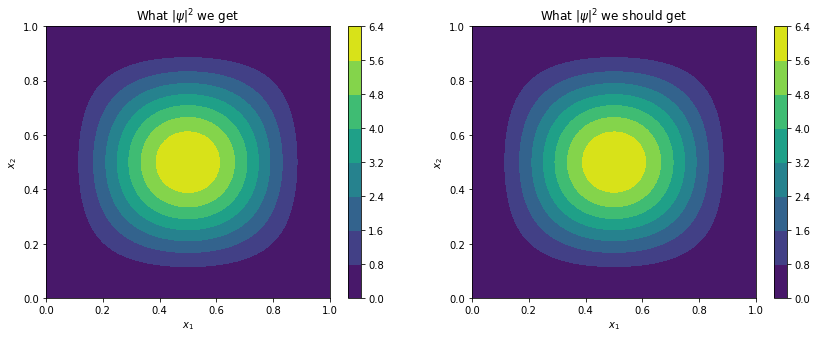


 Epoch 18
-------------------------------
Residual: 1.71085E-12, Energy: 19.74509  [  100 /  1000]
Residual: 1.62036E-12, Energy: 19.74780  [  200 /  1000]
Residual: 9.92984E-13, Energy: 19.74081  [  300 /  1000]
Residual: 1.94407E-12, Energy: 19.72691  [  400 /  1000]
Residual: 2.04304E-12, Energy: 19.73574  [  500 /  1000]
Residual: 1.10546E-12, Energy: 19.74361  [  600 /  1000]
Residual: 1.79617E-12, Energy: 19.73332  [  700 /  1000]
Residual: 7.52513E-13, Energy: 19.73949  [  800 /  1000]
Residual: 3.94407E-13, Energy: 19.74450  [  900 /  1000]
Residual: 1.24114E-12, Energy: 19.74579  [ 1000 /  1000]


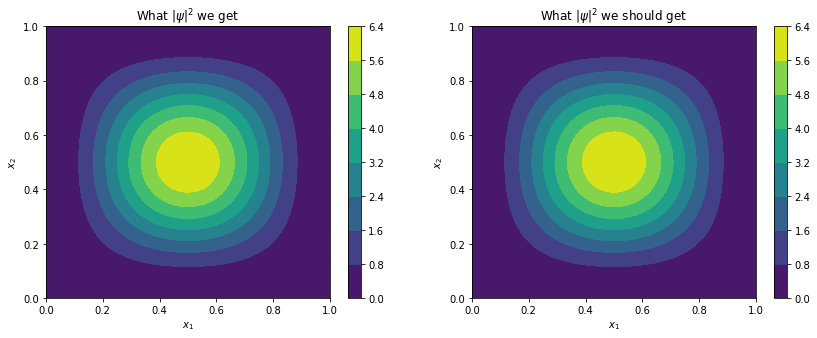


 Epoch 19
-------------------------------
Residual: 4.61688E-13, Energy: 19.74183  [  100 /  1000]
Residual: 3.15957E-13, Energy: 19.73869  [  200 /  1000]
Residual: 7.12068E-13, Energy: 19.73527  [  300 /  1000]
Residual: 2.68014E-13, Energy: 19.74010  [  400 /  1000]
Residual: 8.21120E-13, Energy: 19.74434  [  500 /  1000]
Residual: 2.19550E-13, Energy: 19.74315  [  600 /  1000]
Residual: 8.33771E-13, Energy: 19.74837  [  700 /  1000]
Residual: 2.18168E-13, Energy: 19.74235  [  800 /  1000]
Residual: 1.21448E-13, Energy: 19.74306  [  900 /  1000]
Residual: 1.21750E-13, Energy: 19.74198  [ 1000 /  1000]


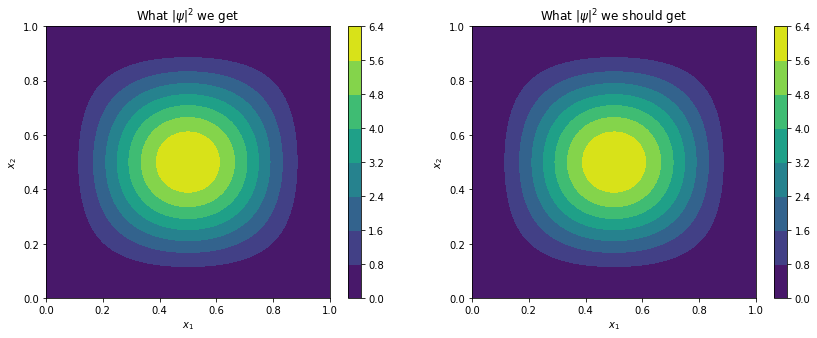


 Epoch 20
-------------------------------
Residual: 1.63565E-13, Energy: 19.74022  [  100 /  1000]
Residual: 4.84870E-12, Energy: 19.75979  [  200 /  1000]
Residual: 1.50839E-13, Energy: 19.74264  [  300 /  1000]
Residual: 4.57994E-13, Energy: 19.73347  [  400 /  1000]
Residual: 5.39178E-13, Energy: 19.73811  [  500 /  1000]
Residual: 1.08364E-11, Energy: 19.74400  [  600 /  1000]
Residual: 2.53677E-10, Energy: 19.81595  [  700 /  1000]
Residual: 3.30542E-10, Energy: 19.71929  [  800 /  1000]
Residual: 5.15593E-12, Energy: 19.73626  [  900 /  1000]
Residual: 2.91598E-12, Energy: 19.78156  [ 1000 /  1000]


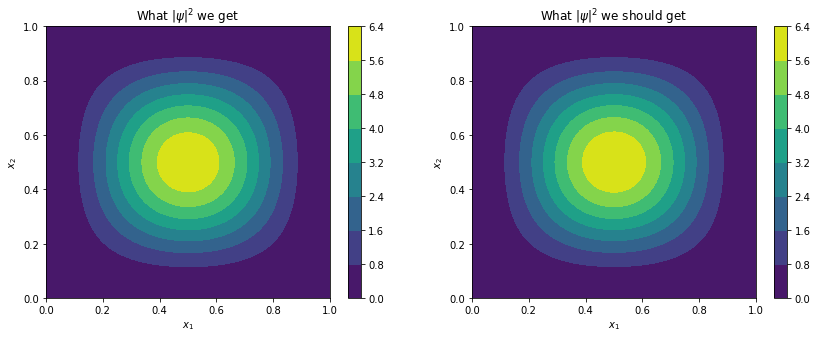


 Epoch 21
-------------------------------
Residual: 3.20259E-12, Energy: 19.75657  [  100 /  1000]
Residual: 2.74102E-12, Energy: 19.74141  [  200 /  1000]
Residual: 1.58785E-12, Energy: 19.75201  [  300 /  1000]
Residual: 1.11404E-12, Energy: 19.73902  [  400 /  1000]
Residual: 1.23101E-12, Energy: 19.75594  [  500 /  1000]
Residual: 5.90015E-13, Energy: 19.75957  [  600 /  1000]
Residual: 1.08116E-12, Energy: 19.73712  [  700 /  1000]
Residual: 6.03326E-13, Energy: 19.72650  [  800 /  1000]
Residual: 9.48900E-13, Energy: 19.74838  [  900 /  1000]
Residual: 4.66024E-13, Energy: 19.76119  [ 1000 /  1000]


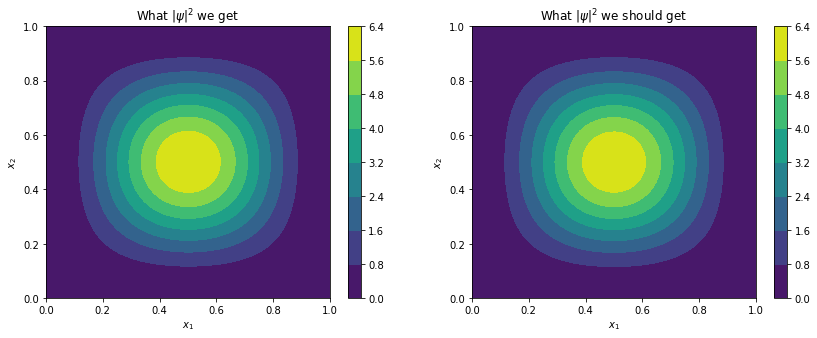


 Epoch 22
-------------------------------
Residual: 3.25348E-13, Energy: 19.75599  [  100 /  1000]
Residual: 3.71485E-13, Energy: 19.71977  [  200 /  1000]
Residual: 1.25082E-13, Energy: 19.72327  [  300 /  1000]
Residual: 3.88335E-13, Energy: 19.67606  [  400 /  1000]
Residual: 1.10283E-13, Energy: 19.74962  [  500 /  1000]
Residual: 1.17991E-13, Energy: 19.79681  [  600 /  1000]
Residual: 2.35412E-13, Energy: 19.71657  [  700 /  1000]
Residual: 8.80840E-14, Energy: 19.76392  [  800 /  1000]
Residual: 1.07966E-13, Energy: 19.61756  [  900 /  1000]
Residual: 2.04941E-13, Energy: 19.79084  [ 1000 /  1000]


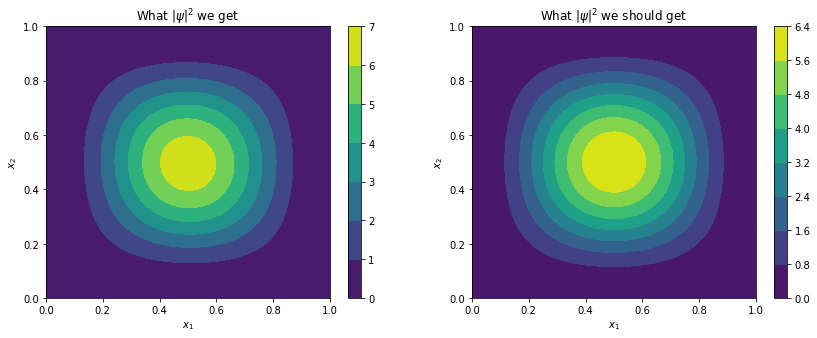


 Epoch 23
-------------------------------
Residual: 4.52299E-14, Energy: 19.87645  [  100 /  1000]
Residual: 1.67082E-13, Energy: 19.74633  [  200 /  1000]
Residual: 6.39070E-14, Energy: 19.82371  [  300 /  1000]
Residual: 5.24979E-13, Energy: 19.70427  [  400 /  1000]
Residual: 1.04962E-09, Energy: 20.01256  [  500 /  1000]
Residual: 3.99732E-12, Energy: 19.76062  [  600 /  1000]
Residual: 1.59961E-12, Energy: 19.73351  [  700 /  1000]
Residual: 2.27697E-12, Energy: 19.74208  [  800 /  1000]
Residual: 2.78584E-12, Energy: 19.76061  [  900 /  1000]
Residual: 7.72571E-13, Energy: 19.76310  [ 1000 /  1000]


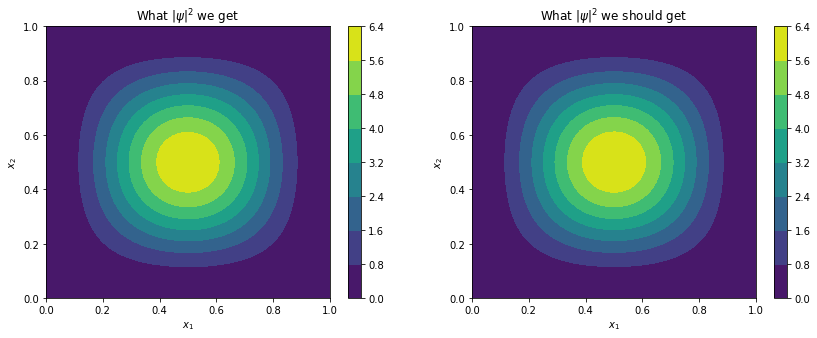


 Epoch 24
-------------------------------
Residual: 8.15871E-13, Energy: 19.72228  [  100 /  1000]
Residual: 7.91911E-13, Energy: 19.77881  [  200 /  1000]
Residual: 2.68048E-13, Energy: 19.75324  [  300 /  1000]
Residual: 2.47140E-13, Energy: 19.71511  [  400 /  1000]
Residual: 2.15317E-12, Energy: 19.71812  [  500 /  1000]
Residual: 1.44980E-12, Energy: 19.79064  [  600 /  1000]
Residual: 1.29817E-11, Energy: 19.79496  [  700 /  1000]
Residual: 1.05694E-09, Energy: 19.73820  [  800 /  1000]
Residual: 9.70342E-11, Energy: 19.73652  [  900 /  1000]
Residual: 7.00319E-11, Energy: 19.72659  [ 1000 /  1000]


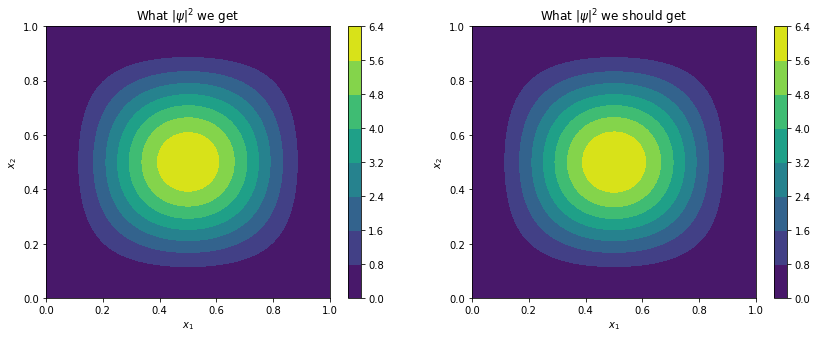


 Epoch 25
-------------------------------
Residual: 3.68628E-11, Energy: 19.73825  [  100 /  1000]
Residual: 1.95981E-11, Energy: 19.75435  [  200 /  1000]
Residual: 2.88830E-11, Energy: 19.74927  [  300 /  1000]
Residual: 1.32243E-11, Energy: 19.73931  [  400 /  1000]
Residual: 8.75632E-12, Energy: 19.73847  [  500 /  1000]
Residual: 7.63325E-12, Energy: 19.75649  [  600 /  1000]
Residual: 5.52087E-12, Energy: 19.74088  [  700 /  1000]
Residual: 4.19143E-12, Energy: 19.72642  [  800 /  1000]
Residual: 3.05367E-12, Energy: 19.74686  [  900 /  1000]
Residual: 5.68338E-12, Energy: 19.75683  [ 1000 /  1000]


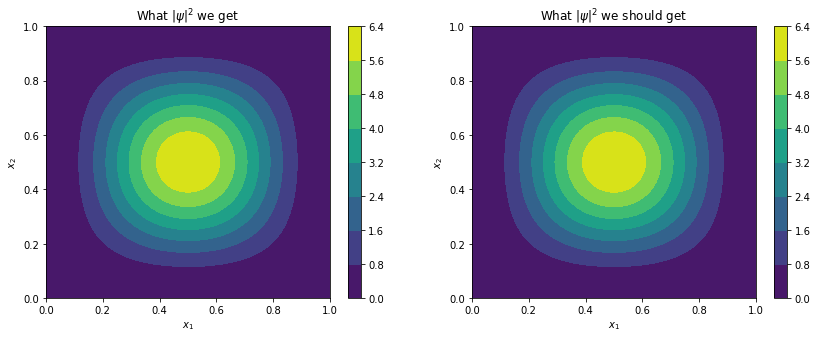

In [ ]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 25
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 1000, wf, optimizer)
  scheduler.step()
  plot_compare_2d(wf)

# 3D

In [ ]:
N = 3
wf = WaveFunction(N, [100]*4).to(device)

In [ ]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 3
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 100, 1000, wf, optimizer)
  scheduler.step()


 Epoch 1
-------------------------------
Residual: 4.55860E-09, Energy: 29.55577  [  100 /  1000]
Residual: 7.23107E-10, Energy: 29.57156  [  200 /  1000]
Residual: 4.43606E-10, Energy: 29.74988  [  300 /  1000]
Residual: 3.39651E-10, Energy: 29.46626  [  400 /  1000]
Residual: 3.22083E-10, Energy: 29.68493  [  500 /  1000]
Residual: 2.57660E-10, Energy: 29.61972  [  600 /  1000]
Residual: 1.62936E-10, Energy: 29.65004  [  700 /  1000]
Residual: 1.97915E-10, Energy: 29.54120  [  800 /  1000]
Residual: 1.85122E-10, Energy: 29.65845  [  900 /  1000]
Residual: 2.03499E-10, Energy: 29.73078  [ 1000 /  1000]

 Epoch 2
-------------------------------
Residual: 2.34295E-10, Energy: 29.74549  [  100 /  1000]
Residual: 1.03584E-10, Energy: 29.58171  [  200 /  1000]
Residual: 2.03832E-10, Energy: 29.78849  [  300 /  1000]
Residual: 1.05205E-10, Energy: 29.68241  [  400 /  1000]
Residual: 9.08270E-11, Energy: 29.59899  [  500 /  1000]
Residual: 7.31093E-11, Energy: 29.55000  [  600 /  1000]
Resi

# ND

In [ ]:
N = 7
wf = WaveFunction(N, [100]*4).to(device)

In [ ]:
optimizer = torch.optim.Adam(params = wf.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 5
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 1000, 1000, wf, optimizer)
  scheduler.step()


 Epoch 1
-------------------------------
Residual: 1.90185E-11, Energy: 70.06302  [  100 /  1000]
Residual: 8.92240E-12, Energy: 71.59585  [  200 /  1000]
294 LOSS FUNCTION IS NAN

 Epoch 2
-------------------------------
0 LOSS FUNCTION IS NAN

 Epoch 3
-------------------------------
0 LOSS FUNCTION IS NAN

 Epoch 4
-------------------------------
0 LOSS FUNCTION IS NAN

 Epoch 5
-------------------------------
0 LOSS FUNCTION IS NAN


In [ ]:
np.pi**2 * 10

98.69604401089359